<a href="https://colab.research.google.com/github/Rakshithts/myprojects/blob/main/text_based_story_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets transformers evaluate rouge-score nltk -q

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
from datasets import load_dataset
import nltk
nltk.download('punkt')

In [ ]:
from datasets import load_dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf

# Load dataset
dataset = load_dataset("mintujupally/ROCStories")
train_stories = dataset["train"]["text"]

# Limit data size
MAX_TRAIN = 5000
train_stories = train_stories[:MAX_TRAIN]

# Initialize tokenizer and fit on texts
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_stories)
total_words = len(tokenizer.word_index) + 1

# Create sequences
input_sequences = []
for story in train_stories:
    token_list = tokenizer.texts_to_sequences([story])[0]
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        input_sequences.append(n_gram_seq)

max_seq_len = max([len(seq) for seq in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre'))

X = input_sequences[:, :-1]
y = tf.keras.utils.to_categorical(input_sequences[:, -1], num_classes=total_words)


In [ ]:
MAX_TRAIN = 3000
train_stories = train_stories[:MAX_TRAIN]

# Rebuild tokenizer on smaller data (optional)
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_stories)
total_words = len(tokenizer.word_index) + 1

# Prepare sequences
input_sequences = []
for story in train_stories:
    token_list = tokenizer.texts_to_sequences([story])[0]
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        input_sequences.append(n_gram_seq)

max_seq_len = max([len(seq) for seq in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre'))

X = input_sequences[:, :-1]
y = tf.keras.utils.to_categorical(input_sequences[:, -1], num_classes=total_words)

print(f"Training on {MAX_TRAIN} stories")
print("Input shape:", X.shape)
print("Output shape:", y.shape)

def build_model(rnn_type="LSTM", vocab_size=total_words, seq_len=max_seq_len-1, embedding_dim=32, units=32):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=seq_len))
    if rnn_type == "LSTM":
        model.add(tf.keras.layers.LSTM(units))
    else:
        model.add(tf.keras.layers.GRU(units))
    model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

print("Training LSTM...")
lstm_model = build_model("LSTM")
history_lstm = lstm_model.fit(X, y, epochs=10, batch_size=16, validation_split=0.1)

print("Training GRU...")
gru_model = build_model("GRU")
history_gru = gru_model.fit(X, y, epochs=10, batch_size=16, validation_split=0.1)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_story(seed_text, model, next_words=50, temperature=1.0):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]

        # Apply temperature to predictions
        preds = np.log(predicted_probs + 1e-8) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        predicted_id = np.random.choice(len(preds), p=preds)

        output_word = tokenizer.index_word.get(predicted_id, '')
        seed_text += ' ' + output_word
    return seed_text

seed = "The boy went to"
print("LSTM generated story:\n", generate_story(seed, lstm_model, temperature=0.8))
print("\nGRU generated story:\n", generate_story(seed, gru_model, temperature=0.8))


LSTM generated story:
 The boy went to be a local building one night one of the morning after days he was angry all of his pieces then she received the gum and smiled i was going to be work drunk there of her wife snowed disappointed bob was able to just go to my hat the other

GRU generated story:
 The boy went to make a cane he was a bunch of his summer time he was sad the placed he stepped on the area and landed on turn he wrote the chance to return out of the same time he was disappointed when he had to picked the news that he is nervous


In [ ]:
seed = "The curious boy discovered an old map hidden in the attic"
print("LSTM generated story:\n", generate_story(seed, lstm_model, temperature=0.8))
print("\nGRU generated story:\n", generate_story(seed, gru_model, temperature=0.8))

LSTM generated story:
 The curious boy discovered an old map hidden in the attic today she grew up for the mail he picked up in the air with her to the same car i ran off i stopped the dream was howl but she is too cry they were upset they be so so so i continued to wait to the next time after

GRU generated story:
 The curious boy discovered an old map hidden in the attic one day they were serviced the mud took him to the chance to buy him and said he was incredibly upset as he finished it into the middle of his team he took on the band bird and the clerk had to be happy that i ran back to the


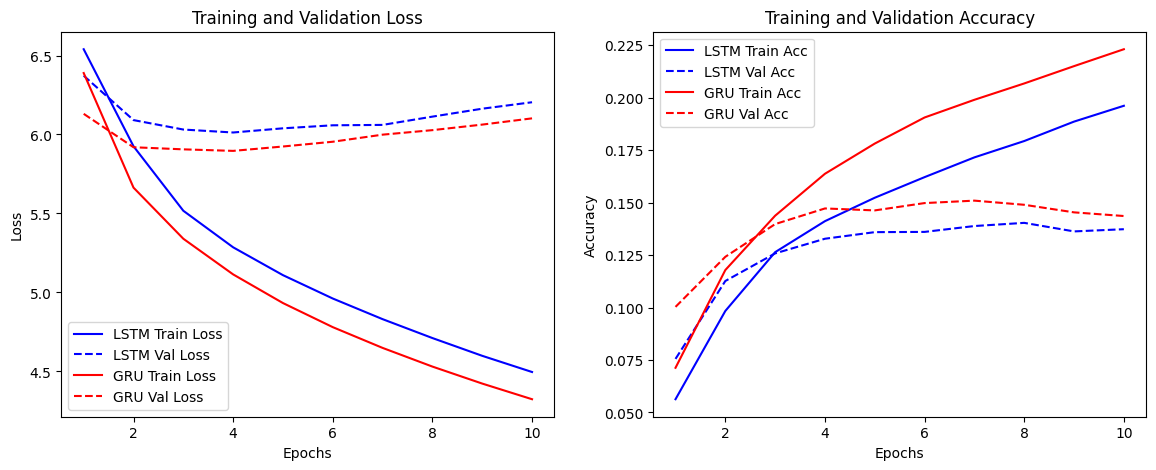

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history_lstm, history_gru):
    epochs = range(1, len(history_lstm.history['loss']) + 1)

    plt.figure(figsize=(14,5))

    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history_lstm.history['loss'], 'b-', label='LSTM Train Loss')
    plt.plot(epochs, history_lstm.history['val_loss'], 'b--', label='LSTM Val Loss')
    plt.plot(epochs, history_gru.history['loss'], 'r-', label='GRU Train Loss')
    plt.plot(epochs, history_gru.history['val_loss'], 'r--', label='GRU Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history_lstm.history['accuracy'], 'b-', label='LSTM Train Acc')
    plt.plot(epochs, history_lstm.history['val_accuracy'], 'b--', label='LSTM Val Acc')
    plt.plot(epochs, history_gru.history['accuracy'], 'r-', label='GRU Train Acc')
    plt.plot(epochs, history_gru.history['val_accuracy'], 'r--', label='GRU Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call the function
plot_training_history(history_lstm, history_gru)


In [ ]:
import nltk
nltk.data.path.append("/root/nltk_data")
nltk.download('punkt', download_dir="/root/nltk_data")


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothie = SmoothingFunction().method4

def simple_tokenize(text):
    return text.lower().split()

def bleu_score(reference, candidate):
    reference_tokens = simple_tokenize(reference)
    candidate_tokens = simple_tokenize(candidate)
    return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothie)

# Evaluate on some test samples
test_samples = dataset['test']['text'][:5]  # first 5 test stories

print("Evaluating BLEU on 5 test samples:")

for i, ref_story in enumerate(test_samples):
    seed_text = ' '.join(ref_story.split()[:8])  # first 8 words as prompt

    gen_lstm = generate_story(seed_text, lstm_model, next_words=50, temperature=0.7)
    gen_gru = generate_story(seed_text, gru_model, next_words=50, temperature=0.7)

    score_lstm = bleu_score(ref_story, gen_lstm)
    score_gru = bleu_score(ref_story, gen_gru)

    print(f"\nSample {i+1} seed: {seed_text}")
    print(f"LSTM BLEU: {score_lstm:.4f}")
    print(f"GRU BLEU: {score_gru:.4f}")


Evaluating BLEU on 5 test samples:

Sample 1 seed: David had achieved his lifelong goal. He had
LSTM BLEU: 0.1326
GRU BLEU: 0.1455

Sample 2 seed: Dave went to Mammoth Mountain to go skiing.
LSTM BLEU: 0.1536
GRU BLEU: 0.1407

Sample 3 seed: Harriet was reading a great book. It was
LSTM BLEU: 0.1518
GRU BLEU: 0.1492

Sample 4 seed: Tina and her friends were heading to the
LSTM BLEU: 0.1415
GRU BLEU: 0.1388

Sample 5 seed: Jimmy had never played football before. He was
LSTM BLEU: 0.1304
GRU BLEU: 0.1492


In [ ]:
import pandas as pd

lstm_scores = []
gru_scores = []
seed_texts = []

test_samples = dataset['test']['text'][:5]

for i, ref_story in enumerate(test_samples):
    seed_text = ' '.join(ref_story.split()[:8])  # first 8 words as prompt
    seed_texts.append(seed_text)

    gen_lstm = generate_story(seed_text, lstm_model, next_words=50, temperature=0.7)
    gen_gru = generate_story(seed_text, gru_model, next_words=50, temperature=0.7)

    score_lstm = bleu_score(ref_story, gen_lstm)
    score_gru = bleu_score(ref_story, gen_gru)

    lstm_scores.append(score_lstm)
    gru_scores.append(score_gru)



In [ ]:
df = pd.DataFrame({
    'Seed Text': seed_texts,
    'LSTM BLEU': lstm_scores,
    'GRU BLEU': gru_scores
})

print(df)



                                        Seed Text  LSTM BLEU  GRU BLEU
0    David had achieved his lifelong goal. He had   0.143518  0.143518
1     Dave went to Mammoth Mountain to go skiing.   0.169050  0.147349
2        Harriet was reading a great book. It was   0.139354  0.151583
3        Tina and her friends were heading to the   0.145471  0.134779
4  Jimmy had never played football before. He was   0.147349  0.147349


In [ ]:
print("Average LSTM BLEU:", df['LSTM BLEU'].mean())
print("Average GRU BLEU:", df['GRU BLEU'].mean())



Average LSTM BLEU: 0.1489485548366723
Average GRU BLEU: 0.14491565497171321


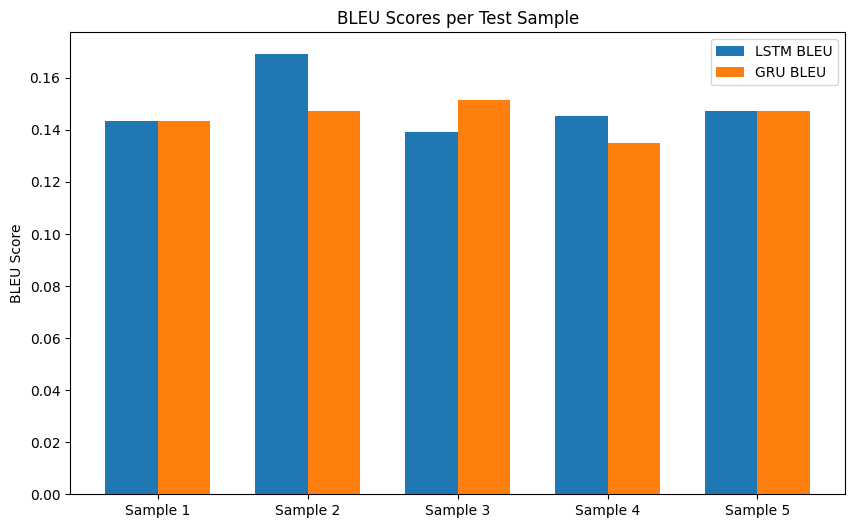

In [ ]:
import matplotlib.pyplot as plt

x = range(len(df))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x, df['LSTM BLEU'], width=width, label='LSTM BLEU')
plt.bar([p + width for p in x], df['GRU BLEU'], width=width, label='GRU BLEU')

plt.xticks([p + width/2 for p in x], [f'Sample {i+1}' for i in x])
plt.ylabel('BLEU Score')
plt.title('BLEU Scores per Test Sample')
plt.legend()
plt.show()
